### Imports

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from graphviz import Digraph
from IPython.display import Image
import os
import imageio.v2 as imageio
from PIL import Image
import random
from scipy.stats import mode

Analizamos el dataset, por ejemplo Credit Amount es una variable continua, no nos sirve. Analizamos con un histograma su distribución y luego decidimos qué hacer. Así con todas las variables continuas o discretas pero con muchos valores.

Min Credit Amount: 250
Max Credit Amount: 18424


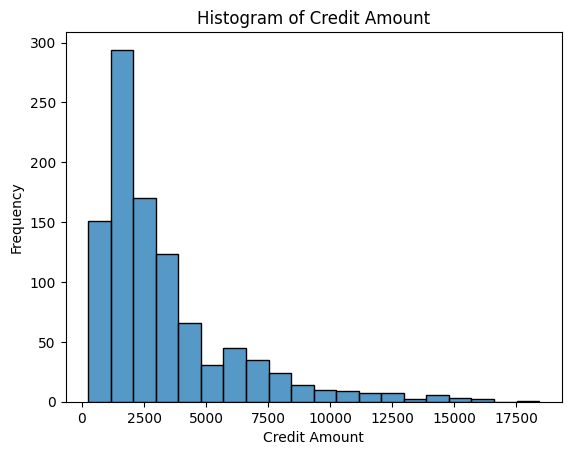

In [71]:
df = pd.read_csv('german_credit.csv')

# get the min and max of the column Credit Amount
min_credit_amount = df['Credit Amount'].min()
max_credit_amount = df['Credit Amount'].max()

print('Min Credit Amount:', min_credit_amount)
print('Max Credit Amount:', max_credit_amount)

# Histogram of Credit Amount
sns.histplot(df['Credit Amount'], bins=20)

plt.title('Histogram of Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.show()


### Discretización de variables continuas o variables discretas con muchos valores

In [72]:
# Discretizar "Credit Amount" en 4 intervalos (cuartiles) usando binning basado en frecuencia
df['Credit Amount'] = pd.qcut(df['Credit Amount'], q=4, labels=[0, 1, 2, 3]) # low, medium, high, very high

# Mostrar las primeras filas del dataset y la nueva columna
print(df['Credit Amount'].head())

# Distribución de los bins (conteo)
print(df['Credit Amount'].value_counts())

# Ver los intervalos de cada bin -> cambiar la primera linea de codigo para que no sobrescriba
# print(pd.qcut(df['Credit Amount'], q=4).value_counts())
# Credit Amount
# (249.999, 1365.5]     250
# (1365.5, 2319.5]      250
# (2319.5, 3972.25]     250
# (3972.25, 18424.0]    250

0    0
1    2
2    0
3    1
4    1
Name: Credit Amount, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
Credit Amount
0    250
1    250
2    250
3    250
Name: count, dtype: int64


In [73]:
df['Duration of Credit (month)'] = pd.qcut(df['Duration of Credit (month)'], q=4, labels=[0, 1, 2, 3]) # short, medium, long, very_long

# Mostrar las primeras filas del dataset y la nueva columna
print(df['Duration of Credit (month)'].head())

# Distribución de los bins (conteo)
print(df['Duration of Credit (month)'].value_counts())

# Ver los intervalos de cada bin -> cambiar la primera linea de codigo para que no sobrescriba
# print(pd.qcut(df['Duration of Credit (month)'], q=4).value_counts())
# Duration of Credit (month)
# (3.999, 12.0]    359
# (24.0, 72.0]     230
# (18.0, 24.0]     224
# (12.0, 18.0]     187

0    1
1    0
2    0
3    0
4    0
Name: Duration of Credit (month), dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
Duration of Credit (month)
0    359
3    230
2    224
1    187
Name: count, dtype: int64


In [74]:
df['Age (years)'] = pd.qcut(df['Age (years)'], q=4, labels=[0, 1, 2, 3]) 

# Mostrar las primeras filas del dataset y la nueva columna
print(df['Age (years)'].head())

# Distribución de los bins (conteo)
print(df['Age (years)'].value_counts())

# Ver los intervalos de cada bin -> cambiar la primera linea de codigo para que no sobrescriba
# print(pd.qcut(df['Age (years)'], q=4).value_counts())
# Duration of Credit (month)
# (18.999, 27.0]    289
# (27.0, 33.0]      225
# (33.0, 42.0]      253
# (42.0, 75.0]      233

0    0
1    2
2    0
3    2
4    2
Name: Age (years), dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
Age (years)
0    289
2    253
3    233
1    225
Name: count, dtype: int64


In [75]:
# Calcular el total de registros
total_records = len(df)

# Ver la distribución de "Purpose"
purpose_counts = df['Purpose'].value_counts()
print(purpose_counts)

# Definir un umbral del 5% del total de registros
threshold = 0.05 * total_records
print('Threshold:', threshold)

# Agrupar las categorías que tienen un conteo menor o igual al 5% en "Otros"
df['Purpose'] = df['Purpose'].apply(lambda x: x if purpose_counts[x] > threshold else 11) # 11 es la categoría "Otros"

# Mostrar la nueva distribución
print(df['Purpose'].value_counts())

Purpose
3     280
0     234
2     181
1     103
9      97
6      50
5      22
10     12
4      12
8       9
Name: count, dtype: int64
Threshold: 50.0
Purpose
3     280
0     234
2     181
11    105
1     103
9      97
Name: count, dtype: int64


### Util Functions

In [76]:
# Función para calcular la precisión
def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)

# Función para calcular la matriz de confusión
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = pd.DataFrame(0, index=classes, columns=classes)
    for true, pred in zip(y_true, y_pred):
        matrix.at[true, pred] += 1
    return matrix

# Función para imprimir el árbol
def print_tree(node, depth=0):
    if node.is_leaf:
        print(" " * depth * 2, "Leaf:", node.value)
    else:
        print(" " * depth * 2, "Attribute:", node.attribute)
        for value, child in node.children.items():
            print(" " * (depth + 1) * 2, "Value:", value)
            print_tree(child, depth + 2)

# ID3

In [85]:

# Definición de la clase Node
class Node:
    def __init__(self, attribute=None, value=None, is_leaf=False, majority_class=None):
        self.attribute = attribute  # Atributo para dividir en este nodo
        self.children = {}          # Diccionario de hijos: valor del atributo -> nodo hijo
        self.value = value          # Clase si es un nodo hoja
        self.is_leaf = is_leaf      # Indicador de nodo hoja
        self.majority_class = majority_class  # Clase mayoritaria en este nodo

    def predict(self, sample):
        if self.is_leaf:
            return self.value
        else:
            attribute_value = sample.get(self.attribute)
            child = self.children.get(attribute_value)
            if child is not None:
                return child.predict(sample)
            else:
                # Si el valor del atributo no se vio durante el entrenamiento
                # Devolvemos la clase mayoritaria en este nodo
                return self.majority_class

# Definición de la clase DecisionTreeBuilder con el flag enable_snapshots
class DecisionTreeBuilder:
    def __init__(self, train_data, test_data, target_attribute, enable_snapshots=False):
        self.snapshot_counter = 0
        self.root = None
        self.snapshots = []
        self.node_counter = 0
        self.train_data = train_data
        self.test_data = test_data
        self.target_attribute = target_attribute
        self.train_accuracies = []
        self.test_preds = []
        self.num_nodes = []
        self.enable_snapshots = enable_snapshots  # Flag para controlar las snapshots

    def entropy(self, data, target_attribute):
        target_values = data[target_attribute]
        counts = target_values.value_counts()
        total = len(target_values)
        ent = 0
        for count in counts:
            p = count / total
            ent -= p * math.log2(p)
        return ent

    def information_gain(self, data, attribute, target_attribute):
        total_entropy = self.entropy(data, target_attribute)
        values = data[attribute].unique()
        weighted_entropy = 0
        total = len(data)
        for value in values:
            subset = data[data[attribute] == value]
            weight = len(subset) / total
            subset_entropy = self.entropy(subset, target_attribute)
            weighted_entropy += weight * subset_entropy
        gain = total_entropy - weighted_entropy
        return gain

    def id3(self, data, attributes, target_attribute, parent_node=None, parent_value=None):
        target_values = data[target_attribute]
        # Si todas las clases son iguales, devolver un nodo hoja
        if len(target_values.unique()) == 1:
            majority_class = target_values.iloc[0]
            leaf_node = Node(value=target_values.iloc[0], is_leaf=True, majority_class=majority_class)
            if parent_node is not None:
                self.connect_node(parent_node, leaf_node, parent_value)
            else:
                self.root = leaf_node
                if self.enable_snapshots:
                    self.generate_snapshot()
                self.node_added()
            return leaf_node
        # Si no hay más atributos, devolver un nodo hoja con la clase mayoritaria
        if len(attributes) == 0:
            majority_value = target_values.mode()[0]
            leaf_node = Node(value=majority_value, is_leaf=True, majority_class=majority_value)
            if parent_node is not None:
                self.connect_node(parent_node, leaf_node, parent_value)
            else:
                self.root = leaf_node
                if self.enable_snapshots:
                    self.generate_snapshot()
                self.node_added()
            return leaf_node
        # Calcular la clase mayoritaria en este nodo
        majority_class = target_values.mode()[0]
        # Seleccionar el mejor atributo
        gains = {attribute: self.information_gain(data, attribute, target_attribute) for attribute in attributes}
        best_attribute = max(gains, key=gains.get)
        node = Node(attribute=best_attribute, majority_class=majority_class)
        if parent_node is not None:
            self.connect_node(parent_node, node, parent_value)
        else:
            self.root = node
            if self.enable_snapshots:
                self.generate_snapshot()
            self.node_added()
        # Para cada valor posible del mejor atributo, crear subárboles
        values = data[best_attribute].unique()
        for value in values:
            subset = data[data[best_attribute] == value]
            if subset.empty:
                # Si el subconjunto está vacío, crear un nodo hoja con la clase mayoritaria
                leaf_node = Node(value=majority_class, is_leaf=True, majority_class=majority_class)
                self.connect_node(node, leaf_node, value)
            else:
                new_attributes = attributes.copy()
                new_attributes.remove(best_attribute)
                subset = subset.drop(columns=[best_attribute])
                self.id3(subset, new_attributes, target_attribute, parent_node=node, parent_value=value)
        return node

    def node_added(self):
        self.node_counter += 1
        # Calcular la precisión en entrenamiento y prueba
        if self.train_data is not None and self.test_data is not None:
            train_preds = self.predict(self.train_data)
            test_preds_aux = self.predict(self.test_data)
            train_acc = accuracy(self.train_data[self.target_attribute], train_preds)
            self.train_accuracies.append(train_acc)
            self.test_preds.append(test_preds_aux)
            self.num_nodes.append(self.node_counter)

    def connect_node(self, parent_node, child_node, value):
        parent_node.children[value] = child_node
        if self.enable_snapshots:
            self.generate_snapshot()
        self.node_added()

    def generate_snapshot(self):
        dot = self.generate_graphviz(self.root)
        filename = f'decision_tree_step_{self.snapshot_counter}'
        dot.render(filename, format='png', cleanup=True)
        self.snapshots.append(f'{filename}.png')
        self.snapshot_counter += 1
        
    def generate_tree_image(self, filename='decision_tree'):
        dot = self.generate_graphviz(self.root)
        dot.render(filename, format='png', cleanup=True)

    def generate_graphviz(self, node, dot=None, parent=None, edge_label=None):
        if dot is None:
            dot = Digraph()
        node_id = str(id(node))
        if node.is_leaf:
            dot.node(name=node_id, label='Leaf: ' + str(node.value), shape='box')
        else:
            dot.node(name=node_id, label=str(node.attribute))
        if parent is not None:
            dot.edge(str(id(parent)), node_id, label=str(edge_label))
        if not node.is_leaf:
            for value, child in node.children.items():
                self.generate_graphviz(child, dot, node, value)
        return dot

    def build_tree(self, data, attributes, target_attribute):
        self.root = self.id3(data, attributes, target_attribute)
        return self.root

    def predict(self, data):
        predictions = []
        for _, sample in data.iterrows():
            prediction = self.root.predict(sample)
            predictions.append(prediction)
        return predictions

    def create_animation(self, output_filename='decision_tree_animation.gif', duration=1):
        if not self.enable_snapshots:
            print("Snapshots were not enabled during tree construction.")
            return
        images = []
        # Determinar el ancho y alto máximos entre todas las imágenes
        max_width = 0
        max_height = 0
        for filename in self.snapshots:
            with Image.open(filename) as img:
                max_width = max(max_width, img.width)
                max_height = max(max_height, img.height)
        # Abrir imágenes y ajustarlas al mismo tamaño
        for filename in self.snapshots:
            with Image.open(filename) as img:
                # Crear una nueva imagen con el tamaño máximo y fondo blanco
                new_img = Image.new('RGBA', (max_width, max_height), (255, 255, 255, 0))
                # Pegar la imagen original en la nueva imagen (centrada)
                x_offset = (max_width - img.width) // 2
                y_offset = (max_height - img.height) // 2
                new_img.paste(img, (x_offset, y_offset))
                images.append(new_img)
        # Guardar imágenes como GIF
        images[0].save(output_filename, save_all=True, append_images=images[1:], duration=duration*1000, loop=0)
        # Opcional: eliminar las imágenes de snapshot después de crear el GIF
        for filename in self.snapshots:
            os.remove(filename)


# Random Forest

In [89]:

# Implementation of Random Forest
class RandomForest:
    def __init__(self, n_estimators, interval_features, min_features, max_features=None, bootstrap=False):
        self.n_estimators = n_estimators
        self.interval_features = interval_features
        self.min_features = min_features
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.trees = []
        self.target_attribute = None
        self.train_data = None
        self.test_data = None
        self.classes = None

    def fit(self, data, target_attribute, train_data, test_data):
        self.target_attribute = target_attribute
        self.classes = data[target_attribute].unique()
        self.train_data = train_data
        self.test_data = test_data

        # Construir cada árbol
        for i in range(self.n_estimators):
            print(f"Construyendo árbol {i+1}/{self.n_estimators}...")

            # Muestra de datos con o sin reemplazo
            if self.bootstrap:
                sample_data = data.sample(frac=1, replace=True, random_state=random.randint(0, 10000))
            else:
                sample_data = data

            # Seleccionar atributos
            if self.max_features is None:
                selected_attributes = [col for col in data.columns if col != target_attribute]
            else:
                attributes = [col for col in data.columns if col != target_attribute]
                k = min(self.max_features, len(attributes))
                selected_attributes = random.sample(attributes, random.randint(min(self.min_features,k-self.interval_features), k))

            # Construir el árbol
            tree_builder = DecisionTreeBuilder(
                target_attribute=target_attribute,
                train_data=self.train_data[selected_attributes + [target_attribute]],
                test_data=self.test_data[selected_attributes + [target_attribute]]
            )
            tree_builder.build_tree(
                sample_data[selected_attributes + [target_attribute]],
                selected_attributes,
                target_attribute
            )

            # Guardar el árbol y sus atributos
            self.trees.append((tree_builder, selected_attributes))

            # Guardar imagen del árbol
            tree_filename = f'decision_tree_{i+1}'
            tree_builder.generate_tree_image(filename=tree_filename)
            print(f"Imagen del árbol guardada como {tree_filename}.png")
        
        self.calculate_train_accuracy()
        self.calculate_test_accuracy()

    def calculate_train_accuracy(self):
        max_length = max(len(tree.train_accuracies) for tree, _ in self.trees)
        accuracy_per_node = []
        
        for i in range(max_length):
            values = []
            for tree, _ in self.trees:
                if i < len(tree.train_accuracies):
                    values.append(tree.train_accuracies[i])
                else:
                    values.append(tree.train_accuracies[-1])
            accuracy_per_node.append(np.mean(values))
            
        self.train_accuracy = accuracy_per_node
        
    def calculate_test_accuracy(self):
        max_length = max(len(tree.test_preds) for tree, _ in self.trees)
        accuracy_per_node = []
        
        for i in range(max_length):
            preds = np.array([
                tree.test_preds[i] if i < len(tree.test_preds) else tree.test_preds[-1]
                for tree, _ in self.trees
            ])
            mo = mode(preds, axis=0)[0]
            mo = mo.flatten()
            accuracy_per_node.append(accuracy(self.test_data[self.target_attribute], mo))
            
        self.test_accuracy = accuracy_per_node
    
    def predict(self, data):
        predictions_list = []
        for tree_builder, attributes in self.trees:
            preds = tree_builder.predict(data[attributes + [self.target_attribute]])
            predictions_list.append(preds)
        final_preds = self.majority_vote(predictions_list)
        return final_preds
    
    def majority_vote(self, predictions_list):
        predictions_array = np.array(predictions_list)
        majority_votes, _ = mode(predictions_array, axis=0)
        majority_votes = majority_votes.flatten()
        return majority_votes

    def evaluate(self, data):
        y_true = data[self.target_attribute]
        y_pred = self.predict(data)
        acc = accuracy(y_true, y_pred)
        return acc, y_true, y_pred

## Train & Visualize

In [79]:
# Suponiendo que el atributo objetivo es 'Creditability' (asegúrate de que coincide con tu conjunto de datos)
target_attribute = 'Creditability'

# Usar todos los atributos excepto el atributo objetivo
attributes = [col for col in df.columns if col != target_attribute]

# Mezclar el conjunto de datos
data = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

### Using Random Forest

Construyendo árbol 1/10...
Imagen del árbol guardada como decision_tree_1.png
Construyendo árbol 2/10...
Imagen del árbol guardada como decision_tree_2.png
Construyendo árbol 3/10...
Imagen del árbol guardada como decision_tree_3.png
Construyendo árbol 4/10...
Imagen del árbol guardada como decision_tree_4.png
Construyendo árbol 5/10...
Imagen del árbol guardada como decision_tree_5.png
Construyendo árbol 6/10...
Imagen del árbol guardada como decision_tree_6.png
Construyendo árbol 7/10...
Imagen del árbol guardada como decision_tree_7.png
Construyendo árbol 8/10...
Imagen del árbol guardada como decision_tree_8.png
Construyendo árbol 9/10...
Imagen del árbol guardada como decision_tree_9.png
Construyendo árbol 10/10...
Imagen del árbol guardada como decision_tree_10.png


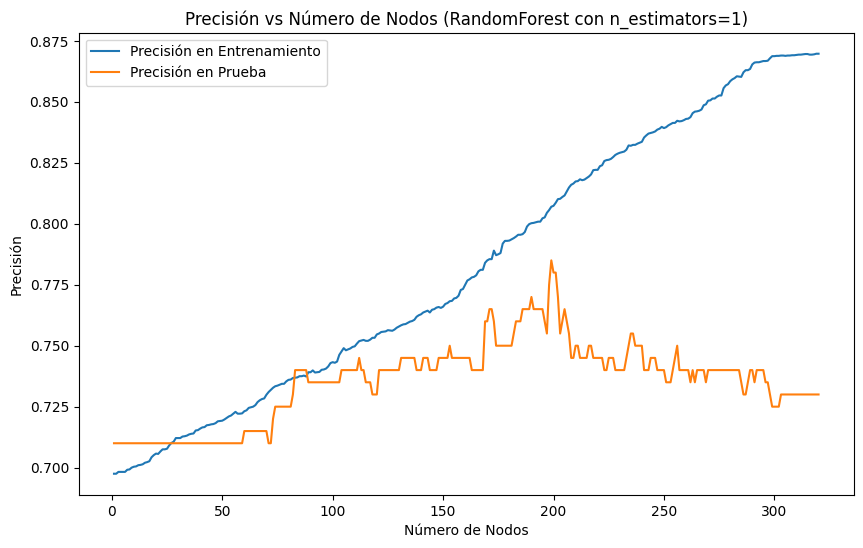

Final test accuracy: 0.7300
Confusion Matrix:
    0    1
0  30   28
1  26  116


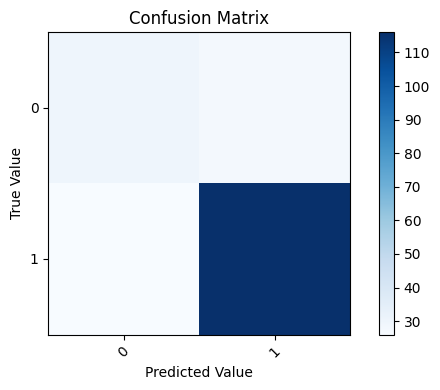

In [91]:
rf = RandomForest(n_estimators=10, interval_features=5, min_features=4, max_features=None, bootstrap=True) # Features: min(4, 20-5) = 4, max(4, 20-5) = 15 -> [4-15)
rf.fit(train_data, target_attribute, train_data, test_data)
train_accuracy = rf.train_accuracy
test_accuracy = rf.test_accuracy
node_counts = range(1, len(train_accuracy)+1)


# Graficar la precisión vs. número de nodos
plt.figure(figsize=(10, 6))
plt.plot(node_counts, train_accuracy, label='Precisión en Entrenamiento')
plt.plot(node_counts, test_accuracy, label='Precisión en Prueba')
plt.xlabel('Número de Nodos')
plt.ylabel('Precisión')
plt.title('Precisión vs Número de Nodos (RandomForest con n_estimators=1)')
plt.legend()
plt.show()

# Evaluate the final model on the test set
test_acc, y_true, y_pred = rf.evaluate(test_data)
print(f"Final test accuracy: {test_acc:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm.columns))
plt.xticks(tick_marks, cm.columns, rotation=45)
plt.yticks(tick_marks, cm.index)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.tight_layout()
plt.show()